# Introvert-Extrovert Classification

In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from statistics import mode
from sklearn.cluster import KMeans

In [334]:
df = pd.read_csv("data/train.csv")
df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [340]:
class KMeansImputer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42, init="k-means++"):
        self.random_state = random_state
        self.init = init

    def fit(self, X, y=None):
        self.columns_ = X.columns
        
        X_temp_imputed = SimpleImputer(strategy="most_frequent").fit_transform(X)
        inertia = []

        for k in range(1, 11):
            kmeans = KMeans(n_clusters=k, random_state=33, init="k-means++")
            kmeans.fit(X_temp_imputed)
            inertia.append(kmeans.inertia_)
            
        plt.plot(range(1, 11), inertia, marker='o')
        plt.title('Elbow Method for Optimal k')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia')
        plt.grid(True)
        plt.show()
        
        self.n_clusters = int(input("Select the k-value you want to train the kmeans model on"))
        
        self.kmeans_fitted = KMeans(n_clusters=self.n_clusters,
                                    random_state=self.random_state,
                                    init=self.init)
        
        df_temp = pd.DataFrame(X, columns=self.columns_,).copy()
        df_temp["Cluster"] = self.kmeans_fitted.fit_predict(X_temp_imputed)
        
        self.cluster_modes_ = {}

        for col in df_temp.columns[:-1]:  # Skip 'Cluster'
            self.cluster_modes_[col] = {}
            for cluster_id in range(self.n_clusters):
                values = df_temp.loc[
                    (df_temp["Cluster"] == cluster_id) & (~df_temp[col].isna()),
                    col
                ]
                if not values.empty:
                    self.cluster_modes_[col][cluster_id] = mode(values)
                else:
                    self.cluster_modes_[col][cluster_id] = None  # fallback if all NaN

        return self

    def transform(self, X):
        X_copy = X.copy()
        X_temp = SimpleImputer(strategy="most_frequent").fit_transform(X)
        clusters = self.kmeans_fitted.predict(X_temp)

        df_imputed = pd.DataFrame(X_copy, columns=self.columns_)
        df_imputed["Cluster"] = clusters

        for col in df_imputed.columns[:-1]:  # exclude 'Cluster'
            for cluster_id in range(self.n_clusters):
                mask = (df_imputed["Cluster"] == cluster_id) & (df_imputed[col].isna())
                fill_value = self.cluster_modes_[col][cluster_id]
                if fill_value is not None:
                    df_imputed.loc[mask, col] = fill_value

        return df_imputed.drop(columns=["Cluster"])


In [341]:
from sklearn.base import BaseEstimator, TransformerMixin

class BinaryTransformation(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        X["Stage_fear"] = X["Stage_fear"].replace({"No":0, "Yes":1})
        X["Drained_after_socializing"] = X["Drained_after_socializing"].replace({"No": 0, "Yes": 1})
        
        return X

In [342]:
data_cleaning = Pipeline([
    ("binary_transformation", BinaryTransformation()),
    ("kmeans_imputing", KMeansImputer()),
    ("scaler", StandardScaler())
])

In [343]:
X = df.drop(["Personality", "id"], axis=1)
y = df["Personality"]

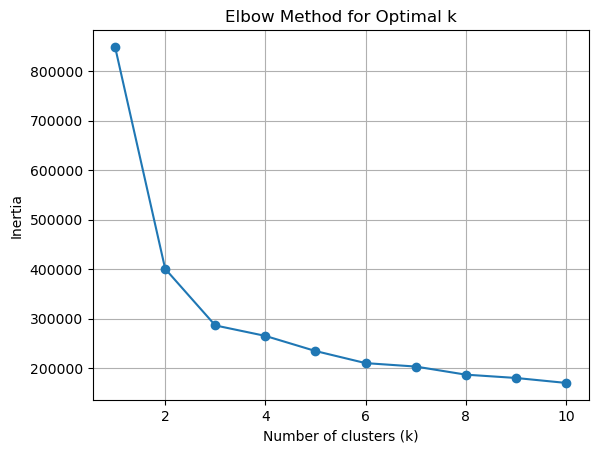

In [344]:
x_binary = data_cleaning.fit_transform(X)

In [345]:
imputer = SimpleImputer(strategy="most_frequent")
x_filled = imputer.fit_transform(x_binary)

In [346]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1013.2+ KB


In [347]:
from sklearn.cluster import KMeans

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=33, init="k-means++")
    kmeans.fit(x_filled)
    inertia.append(kmeans.inertia_)

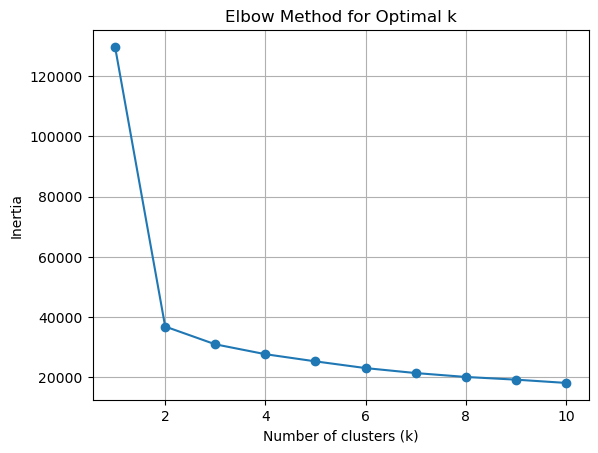

In [348]:
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [349]:
kmeans_fitted = KMeans(n_clusters=2, random_state=44, init="k-means++")
clusters = kmeans_fitted.fit_predict(x_filled)
df["Cluster"] = clusters

In [350]:
from statistics import mode

df_imputed = df.copy()
for col in df.columns[:-1]:
    
    for cluster_id in df['Cluster'].unique():
        
        mask = (df['Cluster'] == cluster_id) & (df[col].isna())
        mean_val = mode(df.loc[(df['Cluster'] == cluster_id) & (~df[col].isna()), col])
        df_imputed.loc[mask, col] = mean_val

In [351]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_filled)

In [352]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver="newton-cholesky")
log_reg.fit(x_scaled, y)

LogisticRegression(solver='newton-cholesky')

In [ ]:
test = pd.read_csv("data/test.csv")
X_test = test.drop(["id"], axis=1)

In [ ]:
x_test_binary = data_cleaning.transform(X_test)

In [ ]:
X_test_fitted = imputer.transform(x_test_binary)

In [ ]:
predicts = log_reg.predict(X_test_fitted)

test["Personality"] = predicts
format_predicts = test[["id", "Personality"]]

format_predicts.to_csv("data/predict.csv", index=False)